In [1]:

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def zillow_data():
    '''
    This fucnction reads the Zillow data from the Codeupdb 
    into a data frame 
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                WHERE propertylandusetypeid = 261 OR propertylandusetypeid = 279
                """
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    df.rename(columns={'bedroomcnt':'bedrooms',\
                   'bathroomcnt':'bathrooms',\
                   'calculatedfinishedsquarefeet':'sqft',\
                   'taxvaluedollarcnt':'tax_value',\
                   'yearbuilt':'year_built',\
                   'taxamount':'tax_amount'}, inplace=True)



    return df

In [3]:
df =zillow_data()

<bound method NDFrame.head of          bedrooms  bathrooms    sqft  tax_value  year_built  tax_amount  \
0             0.0        0.0     NaN    27516.0         NaN         NaN   
1             0.0        0.0     NaN       10.0         NaN         NaN   
2             0.0        0.0     NaN       10.0         NaN         NaN   
3             0.0        0.0     NaN     2108.0         NaN      174.21   
4             4.0        2.0  3633.0   296425.0      2005.0     6941.39   
...           ...        ...     ...        ...         ...         ...   
2152859       4.0        3.0  2262.0   960756.0      2015.0    13494.52   
2152860       4.0        4.5  3127.0   536061.0      2014.0     6244.16   
2152861       0.0        0.0     NaN   208057.0         NaN     5783.88   
2152862       3.0        2.5  1974.0   424353.0      2015.0     5302.70   
2152863       4.0        4.0  2110.0   554009.0      2014.0     6761.20   

           fips  
0        6037.0  
1        6037.0  
2        6037.0

In [4]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [6]:
#**************************************************Distributions*******************************************************

def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()


In [5]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount'])
    
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='median')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test    


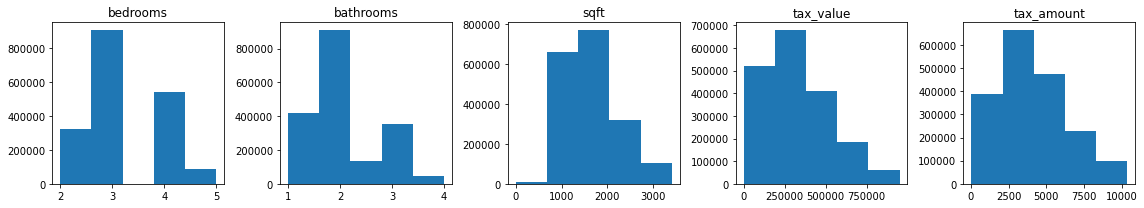

<ipython-input-5-4086035ea71f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['year_built']] = imputer.transform(train[['year_built']])
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-5-4086035ea71f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

(         bedrooms  bathrooms    sqft  tax_value  year_built  tax_amount  \
 10057         4.0        2.0  1561.0   248240.0      1973.0     2504.40   
 2004970       3.0        2.0  1770.0    88390.0      1960.0     1671.93   
 306031        2.0        1.0  1452.0    81169.0      1946.0     1310.88   
 1038595       3.0        1.0  1000.0   119174.0      1950.0     1900.28   
 270959        3.0        2.0  1974.0   432268.0      1988.0     5315.27   
 ...           ...        ...     ...        ...         ...         ...   
 991122        3.0        1.0  1199.0   280857.0      1951.0     3282.40   
 1707759       4.0        2.0  1859.0    95008.0      1961.0     1463.61   
 1770246       3.0        3.0  2132.0   158470.0      1980.0     2037.38   
 1500741       2.0        1.0   780.0   477167.0      1955.0     6509.69   
 843328        3.0        1.0  1132.0   285700.0      1916.0     3563.75   
 
            fips  
 10057    6059.0  
 2004970  6037.0  
 306031   6037.0  
 1038595  

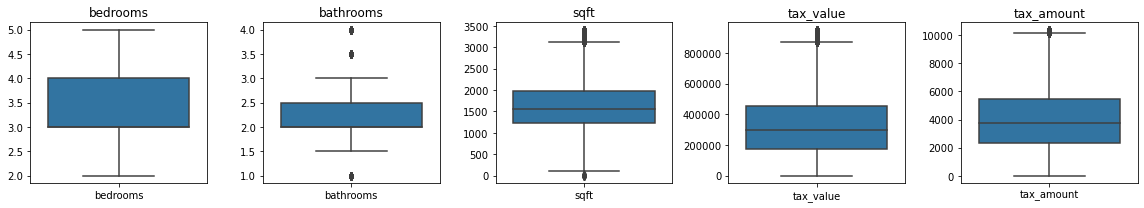

In [7]:
prepare_zillow(df)

In [8]:
train

NameError: name 'train' is not defined